Circle 1: Intersection type: MultiPoint
Circle 2: Intersection type: MultiPoint
Circle 3: Intersection type: MultiPoint
Circle 4: Intersection type: MultiPoint


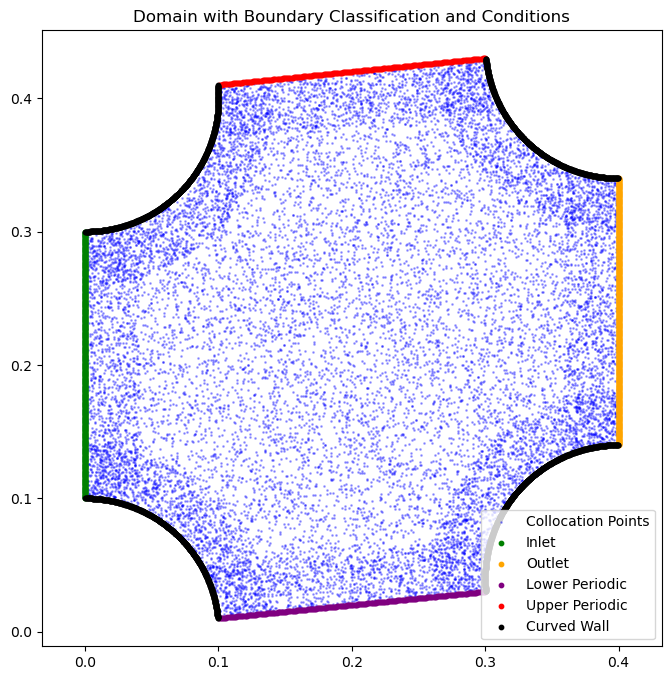

Data saved successfully to C:\Users\mahir.mobarrat\Downloads\UP_0.5_10.csv


In [55]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from scipy.interpolate import griddata

# Global parameters
d_s = 0.4
x_min, x_max = 0, d_s
N_c = 10000           # Collocation points 6000
N_b_in_out = 500     # Inlet/outlet boundary points 500
N_p = 252            # Periodic boundary points 500
N_w = 8000          # Wall points 2000
refinement_radius = d_s/10
N_refined = 750     # Refined points for periodic boundaries 1500
N_f = 4000           # Refined wall points 3000
N_refined_inlet_outlet = 750  # Refined inlet/outlet points 1500

def generate_random_points(n_points, domain, x_range, y_range):
    """Efficiently generate n_points inside the given domain using batch sampling."""
    points = []
    batch_size = n_points * 2  # Oversample to reduce iterations
    while len(points) < n_points:
        xs = np.random.uniform(x_range[0], x_range[1], batch_size)
        ys = np.random.uniform(y_range[0], y_range[1], batch_size)
        candidates = np.column_stack((xs, ys))
        # Filter points using vectorized iteration
        for pt in candidates:
            if domain.contains(Point(pt)):
                points.append(pt.tolist())
                if len(points) >= n_points:
                    break
    return np.array(points)

def getData(circle_radius, n):
    """Create the domain, boundaries, and collocation points based on given parameters."""
    tilt = d_s / n
    y_min_local, y_max_local = 0, d_s + tilt

    # Define the parallelogram domain
    vertices = [
        [x_min, y_min_local],
        [x_min, y_max_local - tilt],
        [x_max, y_max_local],
        [x_max, y_min_local + tilt],
    ]
    parallelogram = Polygon(vertices)

    # Create circular holes
    circle_centers = np.array([
        [0, 0],
        [0, x_max],
        [d_s, tilt],
        [d_s, y_max_local],
    ])
    circles = [Point(center).buffer(circle_radius) for center in circle_centers]
    domain = parallelogram.difference(unary_union(circles))

    # Find intersections between circles and the parallelogram for periodic boundaries
    def find_boundary_intersections():
        intersections = []
        for i, circle in enumerate(circles):
            inter = parallelogram.exterior.intersection(circle.exterior)
            print(f"Circle {i+1}: Intersection type: {inter.geom_type}")
            if inter.is_empty:
                continue
            if inter.geom_type == 'Point':
                intersections.append(list(inter.coords)[0])
            elif inter.geom_type == 'MultiPoint':
                intersections.extend([list(pt.coords)[0] for pt in inter.geoms])
            elif inter.geom_type in ['LineString', 'MultiLineString']:
                if inter.geom_type == 'LineString':
                    intersections.extend(list(inter.coords))
                else:
                    for line in inter:
                        intersections.extend(list(line.coords))
        return np.array(intersections)
    
    all_intersections = find_boundary_intersections()
    if all_intersections.shape[0] >= 8:
        # Group points by x-coordinate
        x_coords = all_intersections[:, 0]
        unique_x = np.unique(x_coords)
        
        # Remove pairs with highest and lowest x values
        middle_x = np.sort(unique_x)[1:-1]
        
        # Filter points with middle x values and get 4 intersection points
        middle_points = all_intersections[np.isin(x_coords, middle_x)]
        
        # Sort by y-coordinate to get proper ordering
        middle_points = middle_points[np.argsort(middle_points[:, 1])]
        
        intersection_points = middle_points
    else:
        print("Not enough intersection points found.")
        intersection_points = np.empty((0, 2))


    # Generate collocation points inside the domain
    xy_col = generate_random_points(N_c, domain, (x_min, x_max), (y_min_local, y_max_local))

    # Define inlet and outlet boundaries
    inlet_y = np.linspace(circle_radius, x_max - circle_radius, N_b_in_out)
    outlet_y = np.linspace(circle_radius + tilt, y_max_local - circle_radius, N_b_in_out)
    inlet = np.column_stack((np.full_like(inlet_y, x_min), inlet_y))
    outlet = np.column_stack((np.full_like(outlet_y, x_max), outlet_y))

    # Define periodic boundaries if sufficient intersections exist
    lower_periodic = upper_periodic = np.empty((0, 2))
    if intersection_points.shape[0] == 4:
        # Compute shared x-coordinates once (from 2 to 8 in your example)
        x_shared = np.linspace(intersection_points[0, 0], intersection_points[1, 0], N_p)
        
        # Compute y-coordinates for the lower and upper boundaries separately
        lower_y = np.linspace(intersection_points[0, 1], intersection_points[1, 1], N_p)
        upper_y = np.linspace(intersection_points[2, 1], intersection_points[3, 1], N_p)
        
        lower_periodic = np.column_stack((x_shared, lower_y))
        upper_periodic = np.column_stack((x_shared, upper_y))
        lower_periodic = lower_periodic[1:-1]
        upper_periodic = upper_periodic[1:-1]

    # Create curved wall points from circles
    wall_points_list = []
    pts_per_circle = N_w // len(circles)
    for circle in circles:
        theta = np.linspace(0, 2 * np.pi, pts_per_circle)
        cx, cy = circle.centroid.x, circle.centroid.y
        pts = np.column_stack((cx + circle_radius * np.cos(theta),
                                cy + circle_radius * np.sin(theta)))
        valid_pts = np.array([pt for pt in pts if parallelogram.contains(Point(pt))])
        wall_points_list.append(valid_pts)
    wall = np.vstack(wall_points_list)

    return y_min_local, y_max_local, xy_col, wall, outlet, lower_periodic, upper_periodic, inlet, domain

def refine_points(boundary, domain, n_refined, refinement_radius):
    """
    Generate refined points near a given boundary.
    This function creates a buffer around the boundary and samples candidate points in batches.
    """
    buffer_union = unary_union([Point(p).buffer(refinement_radius) for p in boundary])
    refined_points = []
    batch_size = n_refined * 2

    # Use the domain bounds to limit y-range
    d_bounds = domain.bounds  # (minx, miny, maxx, maxy)
    x_range = (x_min, x_max)
    y_range = (d_bounds[1], d_bounds[3])

    while len(refined_points) < n_refined:
        xs = np.random.uniform(x_range[0], x_range[1], batch_size)
        ys = np.random.uniform(y_range[0], y_range[1], batch_size)
        candidates = np.column_stack((xs, ys))
        for pt in candidates:
            point = Point(pt)
            if buffer_union.contains(point) and domain.contains(point):
                refined_points.append(pt.tolist())
                if len(refined_points) >= n_refined:
                    break
    return np.array(refined_points)

def process_file(file_path):
    """Process a single CSV file, perform interpolation and save output."""
    dataset = pd.read_csv(file_path)
    
    # Extract parameters from filename (assumes format "DPINN_{radius}_{n}.csv")
    file_name = os.path.basename(file_path).replace('.csv', '')
    parts = file_name.split('_')
    radius = float(parts[1]) * (d_s/2)
    n = int(parts[2])
    
    # Generate domain, boundaries, and collocation points
    y_min_local, y_max_local, xy_col, wall, outlet, lower_periodic, upper_periodic, inlet, domain = getData(radius, n)
    
    # Generate refined points using the common function
    refined_wall = refine_points(wall, domain, N_f, refinement_radius)
    refined_inlet = refine_points(inlet, domain, N_refined_inlet_outlet, refinement_radius)
    refined_outlet = refine_points(outlet, domain, N_refined_inlet_outlet, refinement_radius)
    refined_lower_periodic = refine_points(lower_periodic, domain, N_refined, refinement_radius)
    refined_upper_periodic = refine_points(upper_periodic, domain, N_refined, refinement_radius)
    
    # Combine all points
    xy_col = np.vstack((
        xy_col,
        refined_wall,
        refined_inlet,
        refined_outlet,
        refined_lower_periodic,
        refined_upper_periodic,
        lower_periodic,
        upper_periodic,
        inlet,
        outlet
    ))
    
    # Visualization of domain and boundaries
    plt.figure(figsize=(8, 8))
    plt.scatter(xy_col[:, 0], xy_col[:, 1], s=1, alpha=0.3, color="blue", label="Collocation Points")
    plt.scatter(inlet[:, 0], inlet[:, 1], color="green", s=10, label="Inlet")
    plt.scatter(outlet[:, 0], outlet[:, 1], color="orange", s=10, label="Outlet")
    if lower_periodic.size:
        plt.scatter(lower_periodic[:, 0], lower_periodic[:, 1], color="purple", s=10, label="Lower Periodic")
    if upper_periodic.size:
        plt.scatter(upper_periodic[:, 0], upper_periodic[:, 1], color="red", s=10, label="Upper Periodic")
    plt.scatter(wall[:, 0], wall[:, 1], color="black", s=10, label="Curved Wall")
    plt.legend()
    plt.axis('equal')
    plt.title("Domain with Boundary Classification and Conditions")
    plt.show()
    
    # Interpolate dataset values onto collocation points
    points = dataset[['x', 'y']].values
    values_u = dataset['u'].values
    values_v = dataset['v'].values
    values_p = dataset['p'].values

    interpolated_u = griddata(points, values_u, xy_col, method='linear', fill_value=0)
    interpolated_v = griddata(points, values_v, xy_col, method='linear', fill_value=0)
    interpolated_p = griddata(points, values_p, xy_col, method='linear', fill_value=0)

    # Set constant pressure and velocity boundary conditions
    #interpolated_v[xy_col[:, 0] == x_min] = 0
    interpolated_p[xy_col[:, 0] == x_max] = 0     # Outlet
    
    # Reshape data
    u_all = interpolated_u.reshape(-1)
    v_all = interpolated_v.reshape(-1)
    p_all = interpolated_p.reshape(-1)
    x_all = xy_col[:, 0]
    y_all = xy_col[:, 1]

    lower_start = 12000
    lower_end = 12500  # 0-based indices for lower periodic boundaries
    for i in range(lower_start, lower_end):
        if u_all[i] == 0 and v_all[i] == 0 and p_all[i] == 0:
            if i <= 12249:
                partner_index = i + 250  # corresponding upper periodic index
            else:
                partner_index = i - 250  # corresponding upper periodic index
            #partner_index = i + 250  # corresponding upper periodic index
            u_all[i] = u_all[partner_index]
            v_all[i] = v_all[partner_index]
            p_all[i] = p_all[partner_index]

    # Interpolate pressure on wall points and set wall velocities to zero
    wall_p = griddata(points, values_p, wall, method='linear', fill_value=0)
    wall_u = np.zeros(wall.shape[0])
    wall_v = np.zeros(wall.shape[0])
    
    x_all = np.concatenate((x_all, wall[:, 0]))
    y_all = np.concatenate((y_all, wall[:, 1]))
    u_all = np.concatenate((u_all, wall_u))
    v_all = np.concatenate((v_all, wall_v))
    p_all = np.concatenate((p_all, wall_p))
    
    # Create output DataFrame and save results
    d_value = radius * 2
    output_data = pd.DataFrame({
        'x': x_all,
        'y': y_all,
        'u': u_all,
        'v': v_all,
        'p': p_all,
        'd': d_value
    })
    output_file_path = file_path.replace('DLD_', 'UP_')
    output_data.to_csv(output_file_path, index=False)
    print(f"Data saved successfully to {output_file_path}")

def process_all_files(folder_path):
    """Process all CSV files in the specified folder."""
    for file_name in os.listdir(folder_path):
        if file_name.startswith("DLD_") and file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            process_file(file_path)

if __name__ == '__main__':
    folder_path = r"C:\Users\mahir.mobarrat\Downloads"
    process_all_files(folder_path)


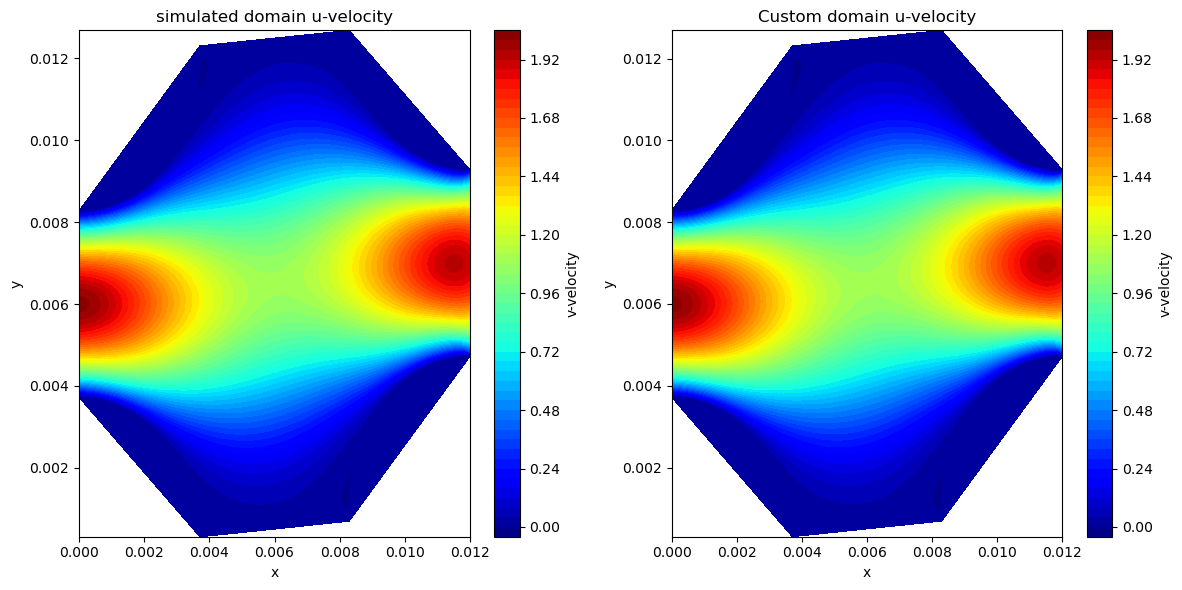

((16500,), (8818,))

In [2]:
#validation actual data from comsol vs interpolated
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

file_path = r"C:\Users\mahir.mobarrat\Desktop\uioy\New folder (2)\Utest_0.62_12_1.csv"
dataset1 = pd.read_csv(file_path)
file_path = r"C:\Users\mahir.mobarrat\Desktop\uioy\New folder (2)\test_0.62_12_1.csv"
dataset2 = pd.read_csv(file_path)

x_grid = dataset1['x'].values  # u-velocity
y_grid = dataset1['y'].values  # u-velocity
values_u = dataset1['u'].values  # u-velocity
values_v = dataset1['v'].values  # v-velocity
values_p = dataset1['p'].values  # Pressure

x_all = dataset2['x'].values  # u-velocity
y_all = dataset2['y'].values  # u-velocity
u_all = dataset2['u'].values  # u-velocity
v_all = dataset2['v'].values  # v-velocity
p_all = dataset2['p'].values  # Pressure



%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_all.min(), values_v.min())
vmax = max(v_all.max(), values_v.max())

# Plotting
plt.figure(figsize=(12, 6))

# Actual u-velocity
plt.subplot(1, 2, 1)
plt.tricontourf(x_grid, y_grid, values_u, levels=50, cmap='jet')
plt.colorbar(label='v-velocity')
plt.title('simulated domain u-velocity')
plt.xlabel('x')
plt.ylabel('y')

# Predicted u-velocity
plt.subplot(1, 2, 2)
plt.tricontourf(x_all, y_all, u_all, levels=50, cmap='jet')
plt.colorbar(label='v-velocity')
plt.title('Custom domain u-velocity')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()

x_grid.shape, x_all.shape

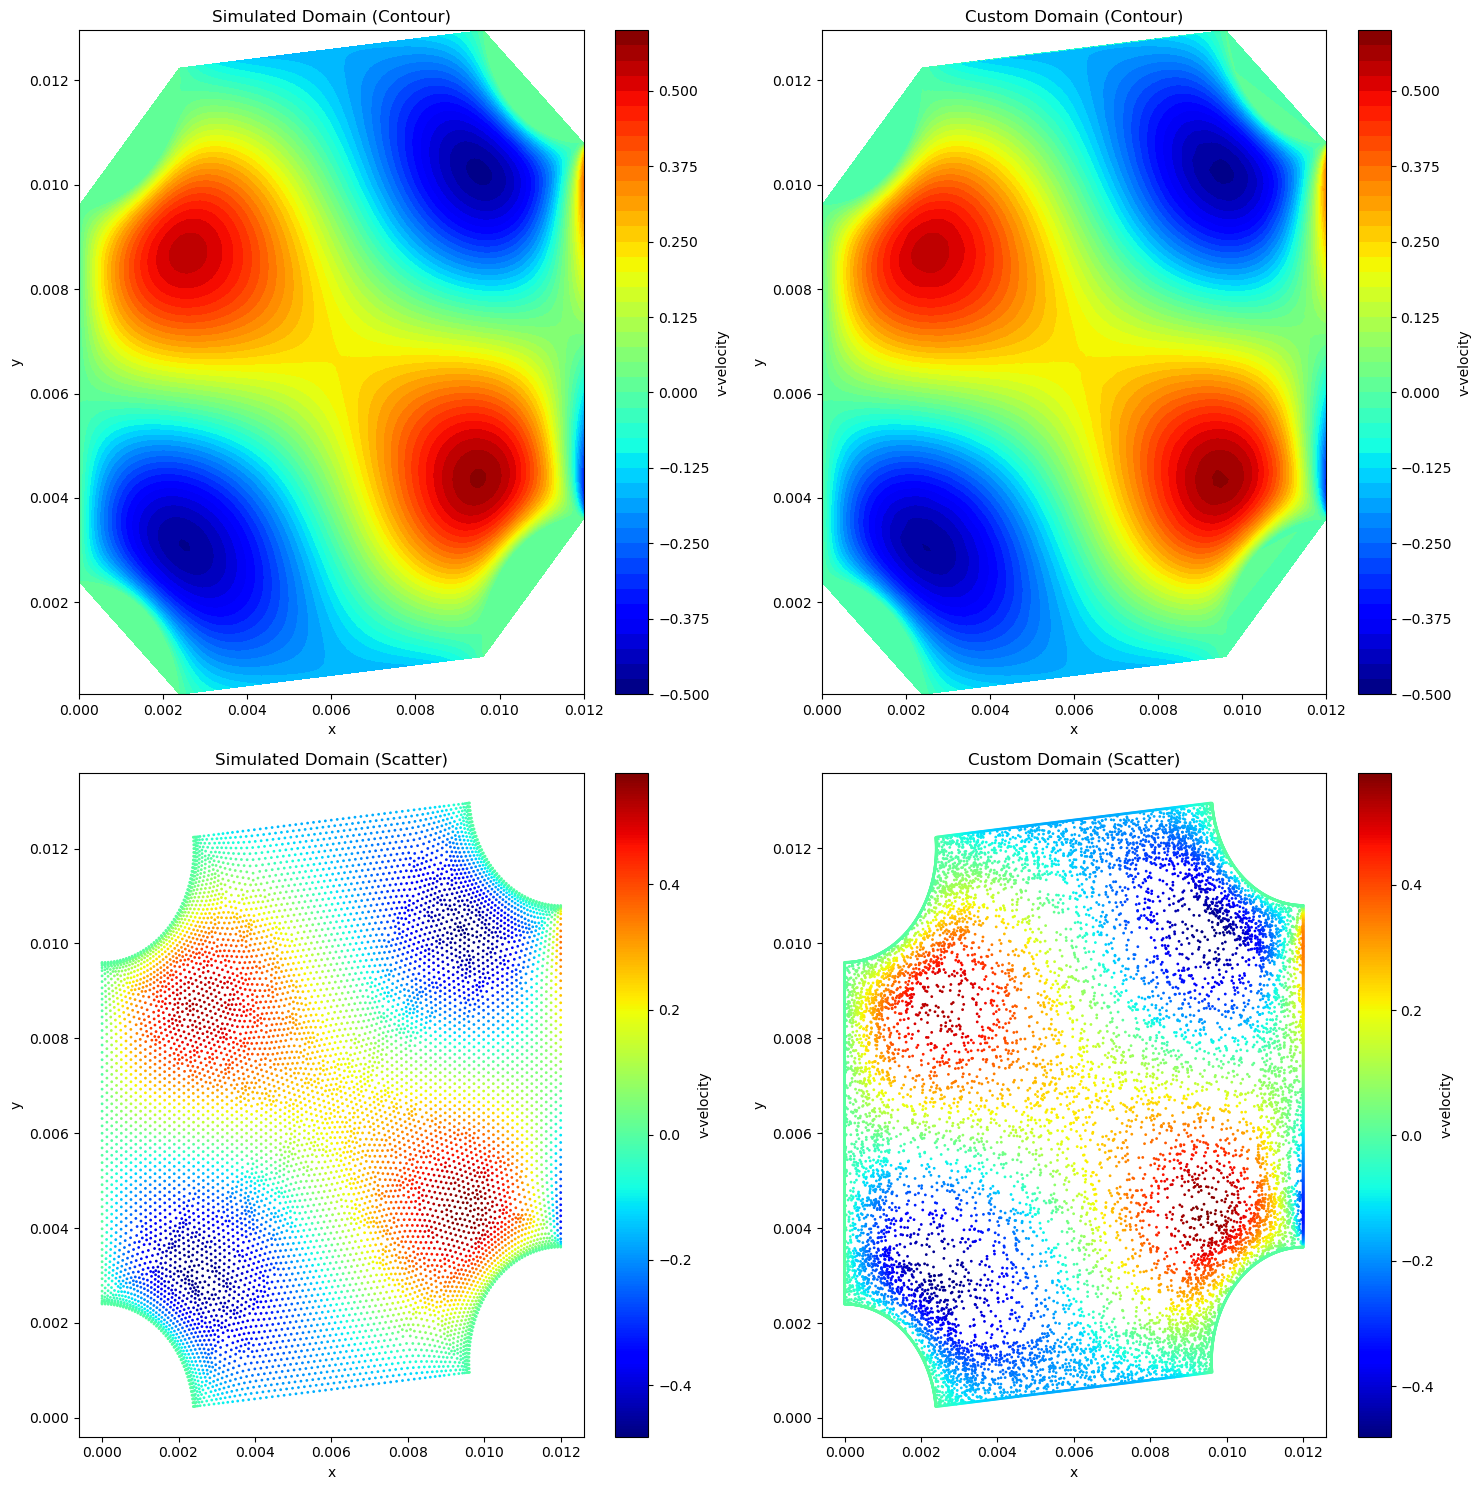

Number of points - Simulated: 9244, Custom: 15500


In [51]:
#validation actual data from comsol vs interpolated
import pandas as pd
import numpy as np
import os
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

file_path = r"C:\Users\mahir.mobarrat\Downloads\DreN_0.4_10_1.csv"
dataset1 = pd.read_csv(file_path)
file_path = r"C:\Users\mahir.mobarrat\Downloads\UPV_0.4_10_1.csv"
dataset2 = pd.read_csv(file_path)

x_grid = dataset1['x'].values  # u-velocity
y_grid = dataset1['y'].values  # u-velocity
values_u = dataset1['u'].values  # u-velocity
values_v = dataset1['v'].values  # v-velocity
values_p = dataset1['p'].values  # Pressure

x_all = dataset2['x'].values  # u-velocity
y_all = dataset2['y'].values  # u-velocity
u_all = dataset2['u'].values  # u-velocity
v_all = dataset2['v'].values  # v-velocity
p_all = dataset2['p'].values  # Pressure

%matplotlib inline

# Determine the common range for colorbar
vmin = min(v_all.min(), values_v.min())
vmax = max(v_all.max(), values_v.max())

# Create a figure with 2 rows and 2 columns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))

# Actual v-velocity contour
cont1 = ax1.tricontourf(x_grid, y_grid, values_v, levels=50, cmap='jet')
plt.colorbar(cont1, ax=ax1, label='v-velocity')
ax1.set_title('Simulated Domain (Contour)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Predicted v-velocity contour
cont2 = ax2.tricontourf(x_all, y_all, v_all, levels=50, cmap='jet')
plt.colorbar(cont2, ax=ax2, label='v-velocity')
ax2.set_title('Custom Domain (Contour)')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

# Actual v-velocity scatter
scatter1 = ax3.scatter(x_grid, y_grid, c=values_v, cmap='jet', s=1)
plt.colorbar(scatter1, ax=ax3, label='v-velocity')
ax3.set_title('Simulated Domain (Scatter)')
ax3.set_xlabel('x')
ax3.set_ylabel('y')

# Predicted v-velocity scatter
scatter2 = ax4.scatter(x_all, y_all, c=v_all, cmap='jet', s=1)
plt.colorbar(scatter2, ax=ax4, label='v-velocity')
ax4.set_title('Custom Domain (Scatter)')
ax4.set_xlabel('x')
ax4.set_ylabel('y')

plt.tight_layout()
plt.show()

print(f"Number of points - Simulated: {x_grid.shape[0]}, Custom: {x_all.shape[0]}")